In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from torchvision import transforms,datasets,models
import json
from torch import nn
from PIL import Image

In [2]:
# To use gpu if applicable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
path = 'flower_data'
if not os.path.exists(path):
    # Download the dataset
    ! wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
    # Unzip and remove the zip file
    ! unzip -q flower_data.zip && rm flower_data.zip

In [4]:
train_path = path+'/train/'
valid_path = path+'/valid/'

# Please check the documentation for further understanding: 
# https://pytorch.org/docs/stable/torchvision/transforms.html

# Class index and name association
with open('flower_cat_to_name.json') as f:
    cat_to_name = json.load(f)
    cat_to_name = {int(k):cat_to_name[k] for k in cat_to_name}

# NB! Since we will use pretrained network for feature extraction, official normalization parameters used.

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Train dataset transformation
train_trans = transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])

# Validation dataset transformation
valid_trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])


train_dataset = datasets.ImageFolder(
        root=train_path,
        transform=train_trans,
)

valid_dataset = datasets.ImageFolder(
        root=valid_path,
        transform=valid_trans
)

batch_size = 64
# Create data loaders using train and valid dataset
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=4)
valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=4)

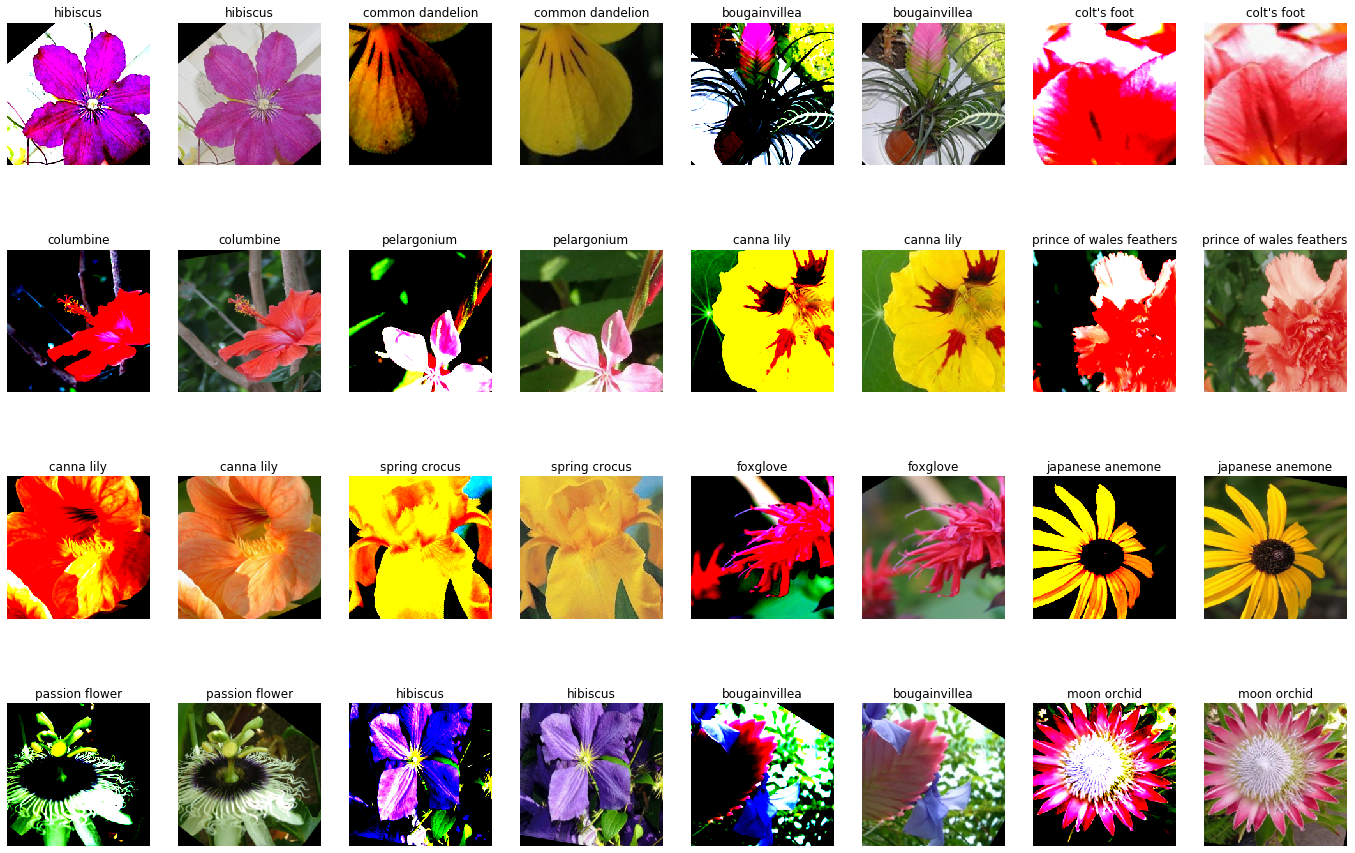

In [9]:
images, labels = next(iter(train_data_loader))
npimgs = images.numpy()[:16] # img is your tensor

# Visualize normalized nad unnormalized images

_, axs = plt.subplots(4, 8, figsize=(24, 16))
axs = axs.flatten()
i = 0
for k,img in enumerate(npimgs):
    label = cat_to_name[labels[k].item()]
    axs[i].imshow(np.clip(np.transpose(img, (1, 2, 0)),0,1))
    axs[i].set_title(label)
    axs[i+1].imshow(np.clip(np.transpose(img, (1, 2, 0))*std+mean,0,1))
    axs[i+1].set_title(label)
    axs[i].axis('off')
    axs[i+1].axis('off')
    i+=2
plt.show()

In [14]:
model = models.densenet161(pretrained=True)
# This is the number of features entering into fc layer
model.classifier.in_features

2208

In [11]:
num_classes = len(train_dataset.classes)
num_classes

102

In [15]:
# Freeze the pretrained weights
for param in model.parameters():
    param.requires_grad = False
    
flower_classifier = nn.Sequential(nn.Linear(model.classifier.in_features, num_classes),
                                  nn.LogSoftmax(dim=1))
model.classifier = flower_classifier

In [16]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_func = nn.NLLLoss()
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [18]:
# Measure the validation loss and accuracy
def validation():
    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in iter(valid_data_loader):
            bs = images.size(0)
            images, labels = images.to(device), labels.to(device) # Move input and label tensors to the GPU
            outputs = model(images)
            loss += loss_func(outputs, labels).item()*bs
            preds = outputs.argmax(dim=1) # get the index of the max log-probability
            correct += (preds == labels).sum().item()
    
    return loss/len(valid_data_loader.dataset), correct/len(valid_data_loader.dataset)

In [19]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    # Iterate over data.
    for _ , (inputs, labels) in enumerate(train_data_loader):
        bs = inputs.size(0)
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        preds = outputs.argmax(dim=1) # get the index of the max log-probability
        running_corrects += (preds == labels).sum().item()
        # backward + optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * bs
    else:   
        model.eval() # Make sure network is in eval mode for inference
        print(running_corrects)
        with torch.no_grad():
            valid_loss, valid_accuracy = validation()
            print("Epoch: {}/{}".format(epoch+1, num_epochs),
                "Training Loss: {:.3f}".format(running_loss/len(train_data_loader.dataset)),
                "Training Accuracy: %{:.2f}".format(100*running_corrects/len(train_data_loader.dataset)),
                "Validation Loss: {:.3f}".format(valid_loss),
                "Validation Accuracy: %{:.2f}".format(100*valid_accuracy))

2939
Epoch: 1/5 Training Loss: 2.984 Training Accuracy: %44.86 Validation Loss: 1.477 Validation Accuracy: %78.97
5316
Epoch: 2/5 Training Loss: 1.272 Training Accuracy: %81.14 Validation Loss: 0.723 Validation Accuracy: %91.69
5747
Epoch: 3/5 Training Loss: 0.796 Training Accuracy: %87.71 Validation Loss: 0.500 Validation Accuracy: %93.15
5876
Epoch: 4/5 Training Loss: 0.612 Training Accuracy: %89.68 Validation Loss: 0.376 Validation Accuracy: %94.62
5994
Epoch: 5/5 Training Loss: 0.494 Training Accuracy: %91.48 Validation Loss: 0.321 Validation Accuracy: %94.87


In [59]:
idx_to_cls = {v:k for k,v in train_data_loader.dataset.class_to_idx.items()}
def predict(img_path='flower_data/valid/26/image_06501.jpg'):
    model.eval()
    img = Image.open(img_path)
    img_org = img.copy()
    img = valid_trans(img)
    model.eval()
    # Batch size is 1
    img = torch.from_numpy(np.expand_dims(img,0))    
    inputs = img.to(device)
    logits = model(inputs)
    # Convert the score to probaiblity from log probability
    prob = np.e**logits.max()
    label = cat_to_name[int(idx_to_cls[logits.argmax(1).item()])]
    plt.figure(figsize=(12,7))
    plt.title("%s, prob: %.2f"%(label,prob))
    plt.imshow(img_org)
    plt.axis('off')
    plt.show()

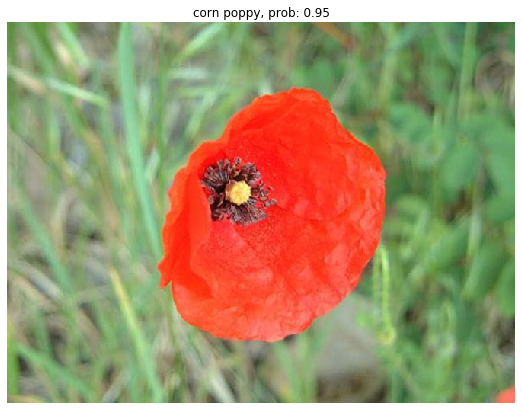

In [60]:
predict()